In [2]:
# Plan 1 GAN Training Notebook

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn.functional as F
import logging
import json
import datetime
from datetime import datetime
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.models import inception_v3
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import sqrtm
from scipy.stats import wasserstein_distance, entropy, spearmanr, gaussian_kde


from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Repository path (adjust if needed)
repo_path = "/content/drive/MyDrive/GAN-thesis-project"

# Add repository path to sys.path for module imports
if repo_path not in sys.path:
    sys.path.append(repo_path)

# Change working directory to the repository
os.chdir(repo_path)

# Verify the working directory
print(f"Current working directory: {os.getcwd()}")


# Set random seed and device
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/GAN-thesis-project
Using device: cpu


In [3]:
# just for you to see what are the implemented function and classes that have been coded up...

import inspect

# Import the entire modules
import src.data_utils as data_utils
import src.cl_loss_function as cl_loss
import src.losses as losses
import src.gan_workflows.plan1.plan1_gan_models as gan_models
import src.gan_workflows.plan1.plan1_gan_training as gan_training

# Function to list functions and classes in a module
def list_functions_and_classes(module):
    members = inspect.getmembers(module)
    functions = [name for name, obj in members if inspect.isfunction(obj)]
    classes = [name for name, obj in members if inspect.isclass(obj)]
    return functions, classes

# Function to print functions and classes in a readable format
def print_functions_and_classes(module_name, module):
    functions, classes = list_functions_and_classes(module)
    print(f"Module: {module_name}")
    print("  Functions:")
    for func in functions:
        print(f"    - {func}")
    print("  Classes:")
    for cls in classes:
        print(f"    - {cls}")
    print()  # Add a blank line for separation

# Print functions and classes for each module
print_functions_and_classes("src.data_utils", data_utils)
print_functions_and_classes("src.cl_loss_function", cl_loss)
print_functions_and_classes("src.losses", losses)
print_functions_and_classes("src.embeddings.encoder_models", gan_models)
print_functions_and_classes("src.embeddings.encoder_training", gan_training)

Module: src.data_utils
  Functions:
    - analyze_embeddings
    - analyze_embeddings_v2
    - create_dataloader
    - create_embedding_loaders
    - generate_embeddings
    - kurtosis
    - load_data
    - load_embeddings
    - load_mnist_data
    - pdist
    - preprocess_images
    - save_embeddings
    - skew
    - split_dataset
    - train_test_split
    - visualize_embeddings
  Classes:
    - DataLoader
    - LocalOutlierFactor
    - TensorDataset

Module: src.cl_loss_function
  Functions:
    - augment
    - compute_nt_xent_loss_with_augmentation
    - compute_triplet_loss_with_augmentation
    - contrastive_loss
    - hflip
    - info_nce_loss
    - resize
  Classes:
    - BYOLLoss
    - BarlowTwinsLoss
    - ContrastiveHead
    - DataLoader
    - NTXentLoss
    - PCA
    - Predictor
    - TensorDataset
    - TripletLoss
    - VicRegLoss

Module: src.losses
  Functions:
    - add_noise
    - cyclical_beta_schedule
    - linear_beta_schedule
    - loss_function_dae_ssim
    - vae

In [4]:
import os

# Base directory where embeddings are stored
embedding_base_dir = "./saved_embeddings/embeddings/"

def list_available_embeddings(base_dir, filter_by=None):
    """
    List available embedding directories and files, optionally filtered by method.

    Args:
        base_dir (str): The base directory containing embeddings.
        filter_by (str or list, optional): Method(s) to filter by (e.g., "autoencoder", "vae").
                                           If None, all embeddings are displayed.
    """
    print("\n📂 Available Embeddings:\n")

    if isinstance(filter_by, str):
        filter_by = [filter_by]  # Convert single filter to list

    for method in sorted(os.listdir(base_dir)):
        method_path = os.path.join(base_dir, method)

        # Check if it's a directory
        if os.path.isdir(method_path):
            if filter_by is None or any(f.lower() in method.lower() for f in filter_by):
                pt_files = [f for f in sorted(os.listdir(method_path)) if f.endswith(".pt")]
                if pt_files:
                    print(f"\n🔹 {method}")  # Show only the category
                    for file in pt_files:
                        print(f"   📄 {method}/{file}")  # Show category + filename

# Default: Show everything
list_available_embeddings(embedding_base_dir)



📂 Available Embeddings:


🔹 autoencoder_AdvancedAutoencoder_barlow_twins
   📄 autoencoder_AdvancedAutoencoder_barlow_twins/AdvancedAutoencoder_barlow_twins_embeddings.pt

🔹 autoencoder_AdvancedAutoencoder_contrastive
   📄 autoencoder_AdvancedAutoencoder_contrastive/AdvancedAutoencoder_contrastive_embeddings.pt

🔹 autoencoder_AdvancedAutoencoder_info_nce
   📄 autoencoder_AdvancedAutoencoder_info_nce/AdvancedAutoencoder_info_nce_embeddings.pt

🔹 autoencoder_AdvancedAutoencoder_mse
   📄 autoencoder_AdvancedAutoencoder_mse/AdvancedAutoencoder_mse_embeddings.pt

🔹 autoencoder_AdvancedAutoencoder_ntxent
   📄 autoencoder_AdvancedAutoencoder_ntxent/AdvancedAutoencoder_ntxent_embeddings.pt

🔹 autoencoder_AdvancedAutoencoder_vicreg
   📄 autoencoder_AdvancedAutoencoder_vicreg/AdvancedAutoencoder_vicreg_embeddings.pt

🔹 autoencoder_EnhancedAutoencoder_barlow_twins
   📄 autoencoder_EnhancedAutoencoder_barlow_twins/EnhancedAutoencoder_barlow_twins_embeddings.pt

🔹 autoencoder_EnhancedAutoencoder_co

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ==========================================
# Critic Model (Discriminator in WGAN-GP)
# ==========================================
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),  # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # 14x14 -> 7x7
            nn.InstanceNorm2d(128),  # Better for WGAN-GP than BatchNorm
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # 7x7 -> 3x3
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 3, 1, 0)  # 3x3 -> 1x1
        )

    def forward(self, x):
        return self.model(x).view(-1)

# ==========================================
# Generator Model (Fixed for 28x28 output)
# ==========================================
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 7, 1, 0, bias=False),  # 1x1 -> 7x7
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 7x7 -> 14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 14x14 -> 28x28
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, 3, 1, 1, bias=False),  # Maintain 28x28
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.latent_dim, 1, 1)
        return self.model(z)

# ==========================================
# Gradient Penalty Function
# ==========================================
def gradient_penalty(critic, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    critic_interpolates = critic(interpolates)

    gradients = autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# ==========================================
# Training Function
# ==========================================
def train_wgan_gp(generator, critic, dataloader, epochs, device, lambda_gp=10, n_critic=5):
    generator.to(device)
    critic.to(device)

    optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.0, 0.9))
    optimizer_C = optim.Adam(critic.parameters(), lr=0.0001, betas=(0.0, 0.9))

    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Train Critic
            optimizer_C.zero_grad()

            # Generate fake images
            z = torch.randn(batch_size, generator.latent_dim, device=device)
            fake_images = generator(z)

            # Critic loss
            real_loss = -torch.mean(critic(real_images))
            fake_loss = torch.mean(critic(fake_images.detach()))
            gp = gradient_penalty(critic, real_images, fake_images.detach(), device)
            loss_C = real_loss + fake_loss + lambda_gp * gp

            loss_C.backward()
            optimizer_C.step()

            # Train Generator less frequently
            if i % n_critic == 0:
                optimizer_G.zero_grad()
                gen_loss = -torch.mean(critic(fake_images))
                gen_loss.backward()
                optimizer_G.step()

        print(f"Epoch {epoch+1}/{epochs} | Critic Loss: {loss_C.item():.4f} | Gen Loss: {gen_loss.item():.4f}")

# ==========================================
# Data Loading
# ==========================================
def get_data_loader(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# ==========================================
# Main Execution
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(latent_dim=100)
critic = Critic()
dataloader = get_data_loader()

train_wgan_gp(generator, critic, dataloader, epochs=50, device=device)

KeyboardInterrupt: 

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ==========================================
# Conditional Generator
# ==========================================
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10, img_channels=1):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)

        self.init_size = 7  # Initial size before upsampling
        self.l1 = nn.Linear(latent_dim + num_classes, 256 * self.init_size**2)

        self.model = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 7x7 -> 14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # 14x14 -> 28x28
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, img_channels, 3, 1, 1, bias=False),   # Maintain 28x28
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate noise and label embedding
        gen_input = torch.cat((self.label_embed(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        return self.model(out)

# ==========================================
# Conditional Discriminator
# ==========================================
class Discriminator(nn.Module):
    def __init__(self, num_classes=10, img_channels=1):
        super(Discriminator, self).__init__()
        self.img_size = 28
        self.num_classes = num_classes

        # Label embedding and processing
        self.label_embed = nn.Embedding(num_classes, num_classes)

        # Adjusted input channels: img_channels + num_classes
        self.model = nn.Sequential(
            nn.Conv2d(img_channels + num_classes, 64, 4, 2, 1),  # Fixed input channels
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(256*3*3, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(256*3*3, num_classes), nn.Softmax(dim=1))

    def forward(self, img, labels):
        # Label processing with proper dimensions
        embedded_labels = self.label_embed(labels)
        embedded_labels = embedded_labels.view(
            embedded_labels.size(0),
            self.num_classes,  # Use num_classes instead of hard-coded 1
            1, 1
        )
        label_map = embedded_labels.repeat(1, 1, self.img_size, self.img_size)

        # Concatenate image and label map
        combined = torch.cat((img, label_map), dim=1)

        features = self.model(combined)
        features = features.view(features.shape[0], -1)

        validity = self.adv_layer(features)
        label_pred = self.aux_layer(features)
        return validity, label_pred

# ==========================================
# Training Function
# ==========================================
def train_cgan(generator, discriminator, dataloader, epochs, device,
              latent_dim=100, num_classes=10):
    generator.to(device)
    discriminator.to(device)

    # Loss functions
    adversarial_loss = nn.BCELoss()
    auxiliary_loss = nn.CrossEntropyLoss()

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for i, (imgs, labels) in enumerate(dataloader):
            batch_size = imgs.shape[0]
            real_imgs = imgs.to(device)
            real_labels = labels.to(device)

            # Adversarial ground truths
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            # ==========================
            #  Train Discriminator
            # ==========================
            optimizer_D.zero_grad()

            # Real images
            real_pred, real_label_pred = discriminator(real_imgs, real_labels)
            d_real_loss = (adversarial_loss(real_pred, valid) +
                          auxiliary_loss(real_label_pred, real_labels)) / 2

            # Fake images
            z = torch.randn(batch_size, latent_dim, device=device)
            gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_imgs = generator(z, gen_labels)
            fake_pred, fake_label_pred = discriminator(fake_imgs.detach(), gen_labels)
            d_fake_loss = (adversarial_loss(fake_pred, fake) +
                          auxiliary_loss(fake_label_pred, gen_labels)) / 2

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # =========================
            #  Train Generator
            # =========================
            optimizer_G.zero_grad()

            # Generate fake images
            gen_imgs = generator(z, gen_labels)
            validity, pred_label = discriminator(gen_imgs, gen_labels)

            # Generator losses
            g_adv_loss = adversarial_loss(validity, valid)
            g_aux_loss = auxiliary_loss(pred_label, gen_labels)
            g_loss = (g_adv_loss + g_aux_loss) / 2

            g_loss.backward()
            optimizer_G.step()

        # Print progress
        print(f"[Epoch {epoch+1}/{epochs}] "
              f"D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}")

# ==========================================
# Data Loading
# ==========================================
def get_data_loader(batch_size=128):
    transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = torchvision.datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# ==========================================
# Main Execution
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
num_classes = 10
epochs = 50

# Initialize models
generator = Generator(latent_dim=latent_dim, num_classes=num_classes)
discriminator = Discriminator(num_classes=num_classes)

# Get data loader
dataloader = get_data_loader()

# Train CGAN
train_cgan(generator, discriminator, dataloader, epochs, device,
          latent_dim=latent_dim, num_classes=num_classes)

KeyboardInterrupt: 

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ==========================================
# ACGAN Generator
# ==========================================
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10, img_channels=1):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, latent_dim)
        self.img_size = 28
        self.latent_dim = latent_dim

        self.init_size = 7  # Starting dimension before upsampling
        self.l1 = nn.Linear(latent_dim * 2, 256 * self.init_size**2)  # Combined noise + label

        self.model = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 7x7 -> 14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # 14x14 -> 28x28
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, img_channels, 3, 1, 1, bias=False),   # Maintain 28x28
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Combine noise and label embedding
        label_embed = self.label_embed(labels)
        gen_input = torch.cat((label_embed, noise), dim=1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 256, self.init_size, self.init_size)
        return self.model(out)

# ==========================================
# ACGAN Discriminator with Auxiliary Classifier
# ==========================================
class Discriminator(nn.Module):
    def __init__(self, num_classes=10, img_channels=1):
        super(Discriminator, self).__init__()
        self.img_size = 28

        # Shared feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Calculate feature dimension
        self.feature_dim = 256 * (self.img_size // 8) ** 2

        # Adversarial head (real/fake)
        self.adv_head = nn.Sequential(
            nn.Linear(self.feature_dim, 1),
            nn.Sigmoid()
        )

        # Auxiliary classification head
        self.aux_head = nn.Sequential(
            nn.Linear(self.feature_dim, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, img):
        features = self.feature_extractor(img)
        features = features.view(features.size(0), -1)

        validity = self.adv_head(features)
        label = self.aux_head(features)
        return validity, label

# ==========================================
# ACGAN Training Function
# ==========================================
def train_acgan(generator, discriminator, dataloader, epochs, device,
               latent_dim=100, num_classes=10):
    generator.to(device)
    discriminator.to(device)

    # Loss functions
    adversarial_loss = nn.BCELoss()
    auxiliary_loss = nn.CrossEntropyLoss()

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for i, (real_imgs, real_labels) in enumerate(dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            real_labels = real_labels.to(device)

            # Adversarial ground truths
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            # ==========================
            #  Train Discriminator
            # ==========================
            optimizer_D.zero_grad()

            # Real images
            real_pred, real_aux = discriminator(real_imgs)
            d_real_loss = (adversarial_loss(real_pred, valid) +
                          auxiliary_loss(real_aux, real_labels)) / 2

            # Fake images
            z = torch.randn(batch_size, latent_dim, device=device)
            gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_imgs = generator(z, gen_labels)
            fake_pred, fake_aux = discriminator(fake_imgs.detach())
            d_fake_loss = (adversarial_loss(fake_pred, fake) +
                          auxiliary_loss(fake_aux, gen_labels)) / 2

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # =========================
            #  Train Generator
            # =========================
            optimizer_G.zero_grad()

            # Generate new fake images
            gen_imgs = generator(z, gen_labels)
            gen_pred, gen_aux = discriminator(gen_imgs)

            # Generator loss combines adversarial and auxiliary losses
            g_loss = (adversarial_loss(gen_pred, valid) +
                     auxiliary_loss(gen_aux, gen_labels)) / 2
            g_loss.backward()
            optimizer_G.step()

        # Print epoch progress
        print(f"[Epoch {epoch+1}/{epochs}] "
              f"D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} "
              f"Real Acc: {(real_aux.argmax(1) == real_labels).float().mean().item():.2f} "
              f"Fake Acc: {(fake_aux.argmax(1) == gen_labels).float().mean().item():.2f}")

# ==========================================
# Data Loading (MNIST)
# ==========================================
def get_data_loader(batch_size=128):
    transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = torchvision.datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# ==========================================
# Main Execution
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
num_classes = 10
epochs = 50

# Initialize models
generator = Generator(latent_dim=latent_dim, num_classes=num_classes)
discriminator = Discriminator(num_classes=num_classes)

# Get data loader
dataloader = get_data_loader()

# Train ACGAN
train_acgan(generator, discriminator, dataloader, epochs, device,
            latent_dim=latent_dim, num_classes=num_classes)

KeyboardInterrupt: 

In [ ]:
def generate_samples(generator, num_samples, labels, device):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 100, device=device)
        labels = torch.tensor(labels, device=device)
        samples = generator(z, labels).cpu()
    return samples

# Generate digit '7' samples
samples = generate_samples(generator, 16, [7]*16, device)

# Display generated images
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ==========================================
# InfoGAN Generator
# ==========================================
class Generator(nn.Module):
    def __init__(self, latent_dim=74, num_classes=10, cont_dim=2):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim  # noise_z (62) + categorical (10) + continuous (2)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, 3, 1, 1, bias=False),              # 32x32 -> 28x28
            nn.Tanh()
        )

    def forward(self, noise, categorical, continuous):
        latent = torch.cat([noise, categorical, continuous], dim=1)
        latent = latent.view(-1, self.latent_dim, 1, 1)
        return self.model(latent)[:, :, 2:30, 2:30]  # Center crop to 28x28

# ==========================================
# Proper 28x28 Discriminator
# ==========================================
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.shared_conv = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),           # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),         # 14x14 -> 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 3, 2, 1),        # 7x7 -> 4x4 (critical fix)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Correct feature dimension: 256 channels * 4x4 = 4096
        self.feature_dim = 256 * 4 * 4

        # Adversarial head
        self.adv_head = nn.Sequential(
            nn.Linear(self.feature_dim, 1),
            nn.Sigmoid()
        )

        # Q Network
        self.q_net = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 10 + 2)  # 10 classes + 2 continuous
        )

    def forward(self, x):
        features = self.shared_conv(x)
        features = features.view(features.size(0), -1)
        validity = self.adv_head(features)
        latent_codes = self.q_net(features)
        return validity, latent_codes

# ==========================================
# Training Function with Mutual Information
# ==========================================
def train_infogan(generator, discriminator, dataloader, epochs, device,
                 noise_dim=62, cat_dim=10, cont_dim=2, lambda_cat=1.0, lambda_cont=0.1):
    generator.to(device)
    discriminator.to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

    # Loss functions
    adversarial_loss = nn.BCELoss()
    categorical_loss = nn.CrossEntropyLoss()
    continuous_loss = nn.MSELoss()

    for epoch in range(epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            # Adversarial ground truths
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            # Generate latent codes
            noise = torch.randn(batch_size, noise_dim, device=device)
            cat_codes = torch.randint(0, cat_dim, (batch_size,), device=device)
            cont_codes = torch.randn(batch_size, cont_dim, device=device)

            # Convert categorical codes to one-hot
            cat_onehot = torch.zeros(batch_size, cat_dim, device=device)
            cat_onehot.scatter_(1, cat_codes.view(-1, 1), 1)

            # ==========================
            #  Train Discriminator
            # ==========================
            optimizer_D.zero_grad()

            # Real images
            real_pred, _ = discriminator(real_imgs)
            d_real_loss = adversarial_loss(real_pred, valid)

            # Fake images
            fake_imgs = generator(noise, cat_onehot, cont_codes)
            fake_pred, _ = discriminator(fake_imgs.detach())
            d_fake_loss = adversarial_loss(fake_pred, fake)

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # =========================
            #  Train Generator
            # =========================
            optimizer_G.zero_grad()

            # Generate fake images
            gen_imgs = generator(noise, cat_onehot, cont_codes)
            gen_pred, latent_pred = discriminator(gen_imgs)

            # Adversarial loss
            g_adv_loss = adversarial_loss(gen_pred, valid)

            # Mutual information loss
            pred_cat = latent_pred[:, :cat_dim]
            pred_cont = latent_pred[:, cat_dim:]

            # Categorical loss
            g_cat_loss = categorical_loss(pred_cat, cat_codes)

            # Continuous loss (assuming Gaussian distribution)
            g_cont_loss = continuous_loss(pred_cont, cont_codes)

            # Total generator loss
            g_loss = g_adv_loss + lambda_cat*g_cat_loss + lambda_cont*g_cont_loss
            g_loss.backward()
            optimizer_G.step()

        # Print progress
        print(f"[Epoch {epoch+1}/{epochs}] "
              f"D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} "
              f"Cat Acc: {(pred_cat.argmax(1) == cat_codes).float().mean().item():.2f} "
              f"Cont Err: {g_cont_loss.item():.4f}")

# ==========================================
# Data Loading (MNIST)
# ==========================================
def get_data_loader(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Keep original 28x28
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = torchvision.datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# ==========================================
# Main Execution
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator = Generator()
discriminator = Discriminator()

# Get data loader
dataloader = get_data_loader()

# Train InfoGAN
train_infogan(generator, discriminator, dataloader, epochs=100, device=device)

KeyboardInterrupt: 

In [ ]:
def generate_samples(generator, noise, categorical, continuous, device):
    generator.eval()
    with torch.no_grad():
        # Convert categorical to one-hot
        cat_onehot = torch.zeros(1, 10, device=device)
        cat_onehot[0, categorical] = 1

        # Generate image
        noise = noise.view(1, -1).to(device)
        continuous = continuous.view(1, -1).to(device)
        sample = generator(noise, cat_onehot, continuous).cpu()
    return sample

# Example: Generate digit 3 with specific style
noise = torch.randn(62)
sample = generate_samples(generator, noise, categorical=3,
                         continuous=torch.tensor([0.5, -0.7]), device=device)

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np

# ==========================================
# Contrastive Augmentation Module
# ==========================================
class MNISTContrastiveTransform:
    def __init__(self):
        self.aug = transforms.Compose([
            transforms.RandomRotation(15),
            transforms.RandomAffine(0, translate=(0.1, 0.1)),
            transforms.RandomApply([transforms.GaussianBlur(3)], p=0.5),
        ])

    def __call__(self, x):
        return self.aug(x), self.aug(x)  # Two augmented views

# ==========================================
# Contrastive Generator
# ==========================================
class ContrastiveGenerator(nn.Module):
    def __init__(self, latent_dim=128, projection_dim=64):
        super().__init__()
        self.latent_dim = latent_dim  # Add this line
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 784),
            nn.Tanh()
        )

        self.projection = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, z):
        img = self.main(z)
        img = img.view(-1, 1, 28, 28)
        features = self.projection(img.view(img.size(0), -1))
        return img, features

# ==========================================
# Contrastive Discriminator
# ==========================================
class ContrastiveDiscriminator(nn.Module):
    def __init__(self, projection_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1)
        )

        self.projection = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

        self.discriminator_head = nn.Linear(256, 1)

    def forward(self, x):
        features = self.encoder(x).squeeze()
        projection = self.projection(features)
        validity = self.discriminator_head(features)
        return validity, projection

# ==========================================
# Contrastive Loss (NT-Xent)
# ==========================================
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, projections):
        # Normalize projections
        projections = nn.functional.normalize(projections, p=2, dim=1)

        # Compute similarity matrix
        sim_matrix = torch.mm(projections, projections.T) / self.temperature

        # Create labels (positive pairs are adjacent in batch)
        batch_size = projections.size(0)
        labels = torch.arange(batch_size, device=projections.device)
        labels = (labels - labels % 2 * 2) + 1  # Pair each element with next

        return self.criterion(sim_matrix, labels)

# ==========================================
# Contrastive GAN Trainer
# ==========================================
class ContrastiveGAN:
    def __init__(self, device='cuda', latent_dim=128, projection_dim=64):
        self.device = device
        self.G = ContrastiveGenerator(latent_dim, projection_dim).to(device)
        self.D = ContrastiveDiscriminator(projection_dim).to(device)

        self.optim_G = optim.Adam(self.G.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.optim_D = optim.Adam(self.D.parameters(), lr=2e-4, betas=(0.5, 0.999))

        self.criterion_adv = nn.BCEWithLogitsLoss()
        self.criterion_cont = ContrastiveLoss(temperature=0.07)

        self.augment = MNISTContrastiveTransform()

    def _get_contrastive_batch(self, real_imgs):
        augmented = [self.augment(img) for img in real_imgs.cpu()]
        view1 = torch.stack([a[0] for a in augmented]).to(self.device)
        view2 = torch.stack([a[1] for a in augmented]).to(self.device)
        return torch.cat([view1, view2], dim=0)

    def train_step(self, real_imgs):
        # Prepare data
        real_imgs = real_imgs.to(self.device)
        batch_size = real_imgs.size(0)

        # Generate fake images
        z = torch.randn(batch_size, self.G.latent_dim, device=self.device)
        fake_imgs, fake_proj = self.G(z)

        # ---------------------
        # Train Discriminator
        # ---------------------
        self.optim_D.zero_grad()

        # Process real images with contrastive views
        cont_batch = self._get_contrastive_batch(real_imgs)
        real_validity, real_proj = self.D(cont_batch)

        # Combine real and fake projections
        D_proj = torch.cat([real_proj, fake_proj.detach()], dim=0)

        # Compute losses
        d_loss_adv = self.criterion_adv(
            real_validity[:batch_size*2],
            torch.ones(batch_size*2, 1, device=self.device)
        )
        d_loss_cont = self.criterion_cont(D_proj)
        d_loss = d_loss_adv + 0.5 * d_loss_cont
        d_loss.backward()
        self.optim_D.step()

        # -----------------
        # Train Generator
        # -----------------
        self.optim_G.zero_grad()

        _, fake_proj = self.D(fake_imgs)
        g_loss_adv = self.criterion_adv(
            self.D(fake_imgs)[0],
            torch.ones(batch_size, 1, device=self.device)
        )
        g_loss_cont = self.criterion_cont(fake_proj)
        g_loss = g_loss_adv + 0.5 * g_loss_cont
        g_loss.backward()
        self.optim_G.step()

        return {
            'd_loss': d_loss.item(),
            'g_loss': g_loss.item(),
            'd_cont': d_loss_cont.item(),
            'g_cont': g_loss_cont.item()
        }

# ==========================================
# Training Pipeline
# ==========================================
def train_contrastive_gan(epochs=100, batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ContrastiveGAN(device=device)

    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(loader):
            metrics = model.train_step(imgs)

            if i % 50 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Batch {i} | "
                      f"D Loss: {metrics['d_loss']:.4f} | G Loss: {metrics['g_loss']:.4f} "
                      f"(D Cont: {metrics['d_cont']:.3f}, G Cont: {metrics['g_cont']:.3f})")

    print("Training complete!")
    return model

# ==========================================
# Sample Generation
# ==========================================
def generate_samples(model, num_samples=16):
    model.G.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 128).to(model.device)
        samples, _ = model.G(z)
        return samples.cpu().numpy()

trained_model = train_contrastive_gan(epochs=50)
samples = generate_samples(trained_model)

# Visualize samples
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

Epoch 1/50 | Batch 0 | D Loss: 3.6839 | G Loss: 3.0856 (D Cont: 6.002, G Cont: 4.852)


KeyboardInterrupt: 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# ==========================
# GAN Building Blocks
# ==========================

import torch.nn as nn

class D_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, strides=2, padding=1, alpha=0.2, dropout=0.3):
        super(D_block, self).__init__()
        self.conv2d = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=kernel_size, stride=strides, padding=padding, bias=False
        )
        self.activation = nn.LeakyReLU(alpha, inplace=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.activation(self.conv2d(x)))

class G_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, strides=2, padding=2):
        super(G_block, self).__init__()
        self.conv2d_trans = nn.ConvTranspose2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=kernel_size, stride=strides, padding=padding, bias=False
        )
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.activation(self.batch_norm(self.conv2d_trans(x)))

# ==========================
# GAN Models
# ==========================

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, 256, kernel_size=4, stride=1, padding=0, bias=False), # Initial upsampling
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # G_block(256, 256),  # Input channels now match
            G_block(256, 128),
            G_block(128, 64),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.latent_dim, 1, 1)  # Reshape to (batch_size, latent_dim, 1, 1)
        return self.model(z)

class Discriminator(nn.Module):  # No changes needed here, but included for completeness
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            D_block(1, 64, kernel_size=4, strides=2, padding=1),  # 28x28 -> 14x14
            D_block(64, 128, kernel_size=4, strides=2, padding=1),  # 14x14 -> 7x7
            D_block(128, 256, kernel_size=3, strides=2, padding=1),  # 7x7 -> 4x4
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),  # 4x4 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)


# ==========================
# WGAN-GP Critic
# ==========================

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            D_block(1, 64, kernel_size=4, strides=2, padding=1),  # 28x28 -> 14x14
            D_block(64, 128, kernel_size=4, strides=2, padding=1),  # 14x14 -> 7x7
            D_block(128, 256, kernel_size=3, strides=2, padding=1),  # 7x7 -> 4x4
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False)  # 4x4 -> 1x1  NO SIGMOID
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

# ==========================
# InfoGAN
# ==========================

class InfoGANGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(InfoGANGenerator, self).__init__()
        self.model = nn.Sequential(
            G_block(latent_dim, 256),
            G_block(256, 128),
            G_block(128, 64),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)

class InfoGANDiscriminator(nn.Module):
    def __init__(self):
        super(InfoGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            D_block(1, 64),
            D_block(64, 128),
            D_block(128, 256),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)
# ==========================
# Conditional GAN (CGAN)
# ==========================

class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            G_block(latent_dim + num_classes, 256),
            G_block(256, 128),
            G_block(128, 64),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = torch.cat((z, self.label_emb(labels)), dim=1)
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            D_block(1 + num_classes, 64),
            D_block(64, 128),
            D_block(128, 256),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        labels = self.label_emb(labels).unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat((x, labels), dim=1)
        return self.model(x).view(-1, 1)

import torch
import torch.nn as nn
import torch.optim as optim

# ==========================
# Contrastive Learning GAN
# ==========================
class ContrastiveGANGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(ContrastiveGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)

class ContrastiveGANDiscriminator(nn.Module):
    def __init__(self):
        super(ContrastiveGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

# ==========================
# Auxiliary Classifier GAN (ACGAN)
# ==========================
class ACGANGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10):
        super(ACGANGenerator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = torch.cat((z, self.label_embedding(labels)), dim=1)
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)

class ACGANDiscriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(ACGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.adv_layer = nn.Sequential(nn.Linear(256*4*4, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(256*4*4, num_classes), nn.Softmax(dim=1))

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        validity = self.adv_layer(x)
        label = self.aux_layer(x)
        return validity, label


import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

def train_gan(generator, discriminator, dataloader, epochs, device):
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in dataloader:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Train discriminator
            optimizer_D.zero_grad()
            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake_images = generator(noise)
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            loss_D = criterion(discriminator(real_images), real_labels) + criterion(discriminator(fake_images.detach()), fake_labels)
            loss_D.backward()
            optimizer_D.step()

            # Train generator
            optimizer_G.zero_grad()
            loss_G = criterion(discriminator(fake_images), real_labels)
            loss_G.backward()
            optimizer_G.step()

        print(f"Epoch {epoch+1}/{epochs} - Loss_D: {loss_D.item()}, Loss_G: {loss_G.item()}")


def train_conditional_gan(generator, discriminator, dataloader, epochs, device, num_classes):
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, labels in dataloader:
            real_images, labels = real_images.to(device), labels.to(device)
            batch_size = real_images.size(0)

            # One-hot encode labels
            labels_onehot = torch.zeros(batch_size, num_classes, device=device)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)

            # Train discriminator
            optimizer_D.zero_grad()
            noise = torch.randn(batch_size, 100, device=device)
            fake_images = generator(noise, labels_onehot)
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            loss_D = criterion(discriminator(real_images, labels_onehot), real_labels) + criterion(discriminator(fake_images.detach(), labels_onehot), fake_labels)
            loss_D.backward()
            optimizer_D.step()

            # Train generator
            optimizer_G.zero_grad()
            loss_G = criterion(discriminator(fake_images, labels_onehot), real_labels)
            loss_G.backward()
            optimizer_G.step()

        print(f"Epoch {epoch+1}/{epochs} - Loss_D: {loss_D.item()}, Loss_G: {loss_G.item()}")


def train_infogan(generator, discriminator, dataloader, epochs, device):
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in dataloader:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Train discriminator
            optimizer_D.zero_grad()
            noise = torch.randn(batch_size, 100, device=device)
            fake_images = generator(noise)
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            loss_D = criterion(discriminator(real_images), real_labels) + criterion(discriminator(fake_images.detach()), fake_labels)
            loss_D.backward()
            optimizer_D.step()

            # Train generator
            optimizer_G.zero_grad()
            loss_G = criterion(discriminator(fake_images), real_labels)
            loss_G.backward()
            optimizer_G.step()

        print(f"Epoch {epoch+1}/{epochs} - Loss_D: {loss_D.item()}, Loss_G: {loss_G.item()}")

def train_contrastive_gan(generator, discriminator, dataloader, epochs, device):
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in dataloader:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            optimizer_D.zero_grad()
            noise = torch.randn(batch_size, 100, device=device)
            fake_images = generator(noise)
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            loss_D = criterion(discriminator(real_images), real_labels) + criterion(discriminator(fake_images.detach()), fake_labels)
            loss_D.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()
            loss_G = criterion(discriminator(fake_images), real_labels)
            loss_G.backward()
            optimizer_G.step()

        print(f"Epoch {epoch+1}/{epochs} - Loss_D: {loss_D.item()}, Loss_G: {loss_G.item()}")

# Define training functions for ACGAN and CycleGAN

def train_acgan(generator, discriminator, dataloader, epochs, device):
    criterion_adv = nn.BCELoss()
    criterion_aux = nn.CrossEntropyLoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, labels in dataloader:
            real_images, labels = real_images.to(device), labels.to(device)
            batch_size = real_images.size(0)

            optimizer_D.zero_grad()
            noise = torch.randn(batch_size, 100, device=device)
            fake_images = generator(noise, labels)
            real_validity, real_aux = discriminator(real_images)
            fake_validity, fake_aux = discriminator(fake_images.detach())

            loss_D = criterion_adv(real_validity, torch.ones_like(real_validity)) + \
                     criterion_adv(fake_validity, torch.zeros_like(fake_validity)) + \
                     criterion_aux(real_aux, labels)
            loss_D.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()
            validity, pred_label = discriminator(fake_images)
            loss_G = criterion_adv(validity, torch.ones_like(validity)) + criterion_aux(pred_label, labels)
            loss_G.backward()
            optimizer_G.step()

        print(f"Epoch {epoch+1}/{epochs} - Loss_D: {loss_D.item()}, Loss_G: {loss_G.item()}")

gan_configurations = {
    "GAN": {
        "generator": Generator,
        "discriminator": Discriminator,
        "train_function": train_gan
    },
    "CGAN": {
        "generator": ConditionalGenerator,
        "discriminator": ConditionalDiscriminator,
        "train_function": train_conditional_gan
    },
    "WGAN-GP": {
        "generator": Generator,
        "critic": Critic,
        "train_function": train_wgan_gp,
        "train_kwargs": {"lambda_gp": 10}
    },
    "InfoGAN": {
        "generator": InfoGANGenerator,
        "discriminator": InfoGANDiscriminator,
        "train_function": train_infogan
    },
    "Contrastive-GAN": {
        "generator": ContrastiveGANGenerator,
        "discriminator": ContrastiveGANDiscriminator,
        "train_function": train_contrastive_gan
    },
    "ACGAN": {
        "generator": ACGANGenerator,
        "discriminator": ACGANDiscriminator,
        "train_function": train_acgan
    }
}

In [11]:
import torch

def check_generator_dimensions(generator_class, latent_dim=100, num_classes=None):
    """Check generator output dimensions."""
    generator = generator_class(latent_dim, num_classes) if num_classes is not None else generator_class(latent_dim)
    generator.eval()

    with torch.no_grad():
        noise = torch.randn(1, latent_dim, 1, 1)
        if num_classes is not None:
            labels = torch.randint(0, num_classes, (1,)).to(torch.long)
            fake_image = generator(noise, labels)
        else:
            fake_image = generator(noise)

    print(f"{generator_class.__name__} output shape: {fake_image.shape}")

def check_discriminator_dimensions(discriminator_class, num_classes=None):
    """Check discriminator input-output dimensions."""
    discriminator = discriminator_class(num_classes) if num_classes is not None else discriminator_class()
    discriminator.eval()

    with torch.no_grad():
        fake_image = torch.randn(1, 1, 28, 28)
        if num_classes is not None:
            labels = torch.randint(0, num_classes, (1,)).to(torch.long)
            score = discriminator(fake_image, labels)
        else:
            score = discriminator(fake_image)

    print(f"{discriminator_class.__name__} output shape: {score.shape}")

# Run checks
check_generator_dimensions(Generator)
check_generator_dimensions(InfoGANGenerator)
check_generator_dimensions(ConditionalGenerator, num_classes=10)
# check_generator_dimensions(ContrastiveGANGenerator)
check_generator_dimensions(ACGANGenerator, num_classes=10)

check_discriminator_dimensions(Discriminator)
check_discriminator_dimensions(Critic)
check_discriminator_dimensions(InfoGANDiscriminator)
check_discriminator_dimensions(ConditionalDiscriminator, num_classes=10)
# check_discriminator_dimensions(ContrastiveGANDiscriminator)
check_discriminator_dimensions(ACGANDiscriminator, num_classes=10)


Generator output shape: torch.Size([1, 1, 32, 32])


TypeError: InfoGANGenerator.forward() missing 2 required positional arguments: 'cat' and 'cont'

Shape of fake_images: torch.Size([16, 1, 28, 28])
Shape of scores: torch.Size([16, 1])


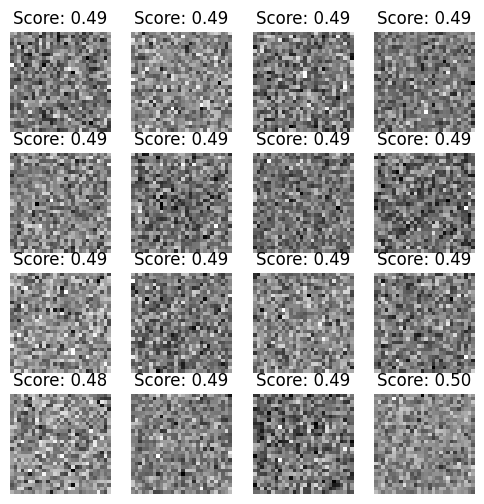

In [55]:
import torch
import matplotlib.pyplot as plt

# ==========================
# FAKE INITIALIZATION FOR DEBUGGING
# ==========================

def generate_fake_samples(gan_type="GAN", latent_dim=100, device="cpu", num_samples=16):
    """Generate fake samples using a random generator initialization."""
    generator = Generator(latent_dim).to(device)
    generator.eval()

    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim, 1, 1, device=device)
        fake_images = generator(noise).cpu()

    return fake_images

# ==========================
# PLOT GENERATED SAMPLES
# ==========================

def plot_fake_samples(fake_images, num_samples=16):
    """Plot generated samples for visualization."""
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    fake_images = fake_images.squeeze().numpy()

    for i, ax in enumerate(axes.flatten()):
        if i < num_samples:
            ax.imshow(fake_images[i], cmap="gray")
            ax.axis("off")

    plt.show()

# ==========================
# RUN DEBUGGING
# ==========================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fake_images = generate_fake_samples(device=device)
print(f"Shape of fake_images: {fake_images.shape}")
plot_fake_samples(fake_images)

# ==========================
# FAKE INITIALIZATION FOR DEBUGGING DISCRIMINATOR
# ==========================

def test_discriminator(gan_type="GAN", device="cpu", num_samples=16):
    """Generate random samples and pass them through the discriminator for debugging."""
    discriminator = Discriminator().to(device)
    discriminator.eval()

    with torch.no_grad():
        fake_images = torch.randn(num_samples, 1, 28, 28, device=device)  # MNIST-like shape
        scores = discriminator(fake_images).cpu()

    return fake_images, scores

# ==========================
# PLOT DISCRIMINATOR OUTPUT
# ==========================

def plot_discriminator_scores(fake_images, scores, num_samples=16):
    """Plot fake images with their corresponding discriminator scores."""
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    fake_images = fake_images.squeeze().numpy()
    scores = scores.squeeze().numpy()

    for i, ax in enumerate(axes.flatten()):
        if i < num_samples:
            ax.imshow(fake_images[i], cmap="gray")
            ax.set_title(f"Score: {scores[i]:.2f}")
            ax.axis("off")

    plt.show()

# ==========================
# RUN DEBUGGING
# ==========================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fake_images, scores = test_discriminator(device=device)
print(f"Shape of fake_images: {fake_images.shape}")
print(f"Shape of scores: {scores.shape}")
plot_discriminator_scores(fake_images, scores)


In [9]:
import os
import json
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from scipy.linalg import sqrtm
from scipy.stats import entropy, spearmanr, gaussian_kde
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from torch.optim import Adam

# ==========================
# CONFIGURATION & DATA LOADING
# ==========================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration
config = {
    "gan_type": "GAN",  # Options: GAN, CGAN, WGAN-GP, InfoGAN
    "latent_dim": 100,
    "num_classes": 10,
    "categorical_dim": 10,
    "epochs": 1,
    "batch_size": 64,
    "learning_rate": 2e-4,
    "device": device,
    "beta1": 0.5,
    "beta2": 0.999,
    "save_path": "gan_model.pth",
    "eval_fraction": 0.1,
    "kl_method": "histogram",
    "show_model_architecture": True,
}

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
num_samples = len(dataset)
eval_size = int(num_samples * config["eval_fraction"])
train_size = num_samples - eval_size

train_data, eval_data = random_split(dataset, [train_size, eval_size])
train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True)
eval_loader = DataLoader(eval_data, batch_size=config["batch_size"], shuffle=False)

config.update({
    "data_loader": train_loader,
    "eval_loader": eval_loader,
})

# ==========================
# MODEL INITIALIZATION
# ==========================

def initialize_gan_components(config):
    """Initialize GAN components based on type."""
    components = {}
    gan_type = config["gan_type"]
    print(f"Initializing {gan_type} components...")

    if gan_type == "GAN":
        components["generator"] = Generator(config["latent_dim"]).to(config["device"])
        components["discriminator"] = Discriminator().to(config["device"])
    elif gan_type == "CGAN":
        components["generator"] = ConditionalGenerator(config["latent_dim"], config["num_classes"]).to(config["device"])
        components["discriminator"] = ConditionalDiscriminator(config["num_classes"]).to(config["device"])
    elif gan_type == "WGAN-GP":
        components["generator"] = Generator(config["latent_dim"]).to(config["device"])
        components["critic"] = Critic().to(config["device"])
    elif gan_type == "InfoGAN":
        components["generator"] = InfoGANGenerator(config["latent_dim"]).to(config["device"])
        components["discriminator"] = InfoGANDiscriminator().to(config["device"])
    else:
        raise ValueError(f"Unsupported GAN type: {gan_type}")

    print(f"Initialized {gan_type} components: {components}")
    if config["show_model_architecture"]:
        for name, model in components.items():
            print(f"{name} architecture:\n{model}")
    return components

# ==========================
# EVALUATION METRICS
# ==========================

def calculate_fid(real_samples, generated_samples, eps=1e-6):
    """Compute Fréchet Inception Distance (FID)."""
    if real_samples.ndim > 2:
        real_samples = real_samples.reshape(real_samples.shape[0], -1)
    if generated_samples.ndim > 2:
        generated_samples = generated_samples.reshape(generated_samples.shape[0], -1)

    mu1, sigma1 = np.mean(real_samples, axis=0), np.cov(real_samples, rowvar=False)
    mu2, sigma2 = np.mean(generated_samples, axis=0), np.cov(generated_samples, rowvar=False)

    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2 + np.eye(sigma1.shape[0]) * eps)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    return np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)

def calculate_kl_divergence(real_samples, generated_samples, method="histogram"):
    """Compute KL divergence between real and generated samples."""
    if method == "histogram":
        real_prob = np.histogram(real_samples, bins=50, density=True)[0]
        gen_prob = np.histogram(generated_samples, bins=50, density=True)[0]
        real_prob += 1e-10
        gen_prob += 1e-10
    elif method == "kde":
        real_kde = gaussian_kde(real_samples.T)
        gen_kde = gaussian_kde(generated_samples.T)
        sample_points = np.linspace(
            min(real_samples.min(), generated_samples.min()),
            max(real_samples.max(), generated_samples.max()),
            100
        )
        real_prob = real_kde(sample_points) + 1e-10
        gen_prob = gen_kde(sample_points) + 1e-10
    else:
        raise ValueError("Invalid method. Choose 'histogram' or 'kde'.")
    return entropy(real_prob, gen_prob)

def calculate_cosine_similarity(real_samples, generated_samples):
    """Compute cosine similarity between real and generated samples."""
    return np.mean(cosine_similarity(real_samples, generated_samples))

def rank_similarity(real_samples, generated_samples):
    """Compute Spearman Rank Correlation."""
    min_size = min(real_samples.shape[0], generated_samples.shape[0])
    real_samples, generated_samples = real_samples[:min_size], generated_samples[:min_size]
    real_rank = np.argsort(real_samples, axis=0)
    gen_rank = np.argsort(generated_samples, axis=0)
    return spearmanr(real_rank.flatten(), gen_rank.flatten()).correlation

def unique_embedding_ratio(generated_samples):
    """Compute the ratio of unique samples in the generated set."""
    unique_samples = np.unique(generated_samples, axis=0)
    return len(unique_samples) / len(generated_samples)

def calculate_wasserstein_distance(real_samples, generated_samples):
    """Compute Wasserstein Distance between real and generated samples."""
    real_samples = (real_samples - np.mean(real_samples)) / (np.std(real_samples) + 1e-8)
    generated_samples = (generated_samples - np.mean(generated_samples)) / (np.std(generated_samples) + 1e-8)
    return wasserstein_distance(real_samples.flatten(), generated_samples.flatten())

def calculate_coverage_score(real_samples, generated_samples, n_neighbors=5):
    """Compute Coverage Score."""
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(generated_samples)
    distances, _ = neigh.kneighbors(real_samples)
    return np.mean(distances[:, 0] < 0.1)

def calculate_memorization_score(real_samples, generated_samples, n_neighbors=1, tolerance=1e-3):
    """Compute Memorization Score."""
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(real_samples)
    distances, _ = neigh.kneighbors(generated_samples)
    return np.mean(distances[:, 0] < tolerance)

def aggregate_quality_score(fid, kl, cosine, rank_corr):
    """Compute a weighted quality score based on multiple metrics."""
    fid_norm = 1 / (1 + fid)
    kl_norm = 1 / (1 + kl)
    cosine_norm = cosine
    rank_norm = (rank_corr + 1) / 2
    return (0.4 * fid_norm) + (0.2 * kl_norm) + (0.2 * cosine_norm) + (0.2 * rank_norm)

def generate_synthetic_samples(generator, num_samples=1000, latent_dim=100, device="cuda"):
    """Generate synthetic samples using a trained GAN generator."""
    generator.eval()
    with torch.no_grad():
        latent_vectors = torch.randn(num_samples, latent_dim, 1, 1, device=device)
        generated_samples = generator(latent_vectors)
    return generated_samples.cpu()

def evaluate_gan(gan_components, config):
    """Evaluate GAN with multiple metrics."""
    device = config["device"]
    generator = gan_components["generator"]

    # Generate synthetic samples
    generated_samples = generate_synthetic_samples(generator, num_samples=1000, latent_dim=config["latent_dim"], device=device)
    generated_dataloader = DataLoader(generated_samples, batch_size=config["batch_size"], shuffle=False)

    # Extract real and generated samples
    real_samples = torch.cat([batch for batch in config["data_loader"]], dim=0).cpu().numpy()
    gen_samples = torch.cat([batch for batch in generated_dataloader], dim=0).cpu().numpy()

    # Flatten the samples if they have more than 2 dimensions
    if real_samples.ndim > 2:
        real_samples = real_samples.reshape(real_samples.shape[0], -1)
    if gen_samples.ndim > 2:
        gen_samples = gen_samples.reshape(gen_samples.shape[0], -1)

    # Calculate metrics
    metrics = {
        "FID": calculate_fid(real_samples, gen_samples),
        "KL Divergence": calculate_kl_divergence(real_samples, gen_samples, method=config["kl_method"]),
        "Cosine Similarity": calculate_cosine_similarity(real_samples, gen_samples),
        "Spearman Rank Correlation": rank_similarity(real_samples, gen_samples),
        "Wasserstein Distance": calculate_wasserstein_distance(real_samples, gen_samples),
        "Coverage Score": calculate_coverage_score(real_samples, gen_samples),
        "Memorization Score": calculate_memorization_score(real_samples, gen_samples),
        "Unique Embedding Ratio": unique_embedding_ratio(gen_samples)
    }

    # Compute aggregate quality score
    metrics["Aggregate Quality Score"] = aggregate_quality_score(
        metrics["FID"],
        metrics["KL Divergence"],
        metrics["Cosine Similarity"],
        metrics["Spearman Rank Correlation"]
    )

    # Print results
    print(json.dumps(metrics, indent=4))

    # Save results
    save_report(metrics, config["gan_type"])

def save_report(metrics, gan_type, embedding_identifier):
    """Saves evaluation metrics as a JSON file."""
    report_filename = f"evaluation_{gan_type}.json"
    report_path = os.path.join("./reports", report_filename)

    with open(report_path, "w") as f:
        json.dump(metrics, f, indent=4)

    print(f"✅ Report saved: {report_path}")

# ==========================
# EXECUTION PIPELINE
# ==========================

# Initialize GAN components
gan_components = initialize_gan_components(config)

# Train the GAN
gan_train_functions = {
    "GAN": train_gan,
    "CGAN": train_conditional_gan,
    "WGAN-GP": train_wgan_gp,
    "InfoGAN": train_infogan,
}

gan_train_functions[config["gan_type"]](gan_components["generator"], gan_components.get("discriminator", gan_components.get("critic")), config["data_loader"], config["epochs"], config["device"])

# Evaluate the GAN
evaluate_gan(gan_components, config)

Initializing GAN components...
Initialized GAN components: {'generator': Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): G_block(
      (conv2d_trans): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): G_block(
      (conv2d_trans): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), bia

TypeError: expected Tensor as element 0 in argument 0, but got list

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Generator Block
class G_block(nn.Module):
    """
    A generator block consisting of a transposed convolution, batch normalization, and LeakyReLU activation.
    """
    def __init__(self, in_channels, out_channels, kernel_size=5, strides=2, padding=2):
        super(G_block, self).__init__()
        self.conv2d_trans = nn.ConvTranspose2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=kernel_size, stride=strides, padding=padding, bias=False
        )
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.activation(self.batch_norm(self.conv2d_trans(x)))


# Simple Generator
class SimpleGenerator(nn.Module):
    """
    A simple generator that maps a latent vector to an image.
    """
    def __init__(self, input_dim):
        super(SimpleGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 7 * 7 * 256),
            nn.BatchNorm1d(7 * 7 * 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (256, 7, 7)),
            G_block(256, 128, 5, 1, 2),
            G_block(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)


# Embedding Generator
class EmbeddingAsInputGenerator(nn.Module):
    """
    A generator that uses embeddings as part of its input.
    """
    def __init__(self, latent_dim, embedding_dim):
        super(EmbeddingAsInputGenerator, self).__init__()
        self.embedding_transform = nn.Linear(embedding_dim, 7 * 7 * 256, bias=False)
        self.model = nn.Sequential(
            nn.BatchNorm1d(7 * 7 * 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (256, 7, 7)),
            G_block(256, 128, 5, 1, 2),
            G_block(128, 64, 5, 2, 2),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z, embedding):
        """
        Forward pass for the generator.

        Args:
            z (torch.Tensor): Latent noise vector of shape (batch_size, latent_dim).
            embedding (torch.Tensor): Embedding vector of shape (batch_size, embedding_dim).

        Returns:
            torch.Tensor: Generated image of shape (batch_size, 1, 28, 28).
        """
        # Ensure embedding has the correct shape
        if embedding.dim() != 2:
            raise ValueError(f"Expected embedding to have shape [batch_size, embedding_dim], got {embedding.shape}")

        # Transform embedding
        transformed_embedding = self.embedding_transform(embedding)  # Shape: [batch_size, 7 * 7 * 256]

        # Reshape to [batch_size, 256, 7, 7]
        transformed_embedding = transformed_embedding.view(-1, 256, 7, 7)

        # Reshape z to match the spatial dimensions of transformed_embedding
        z = z.view(z.size(0), z.size(1), 1, 1)  # Shape: [batch_size, latent_dim, 1, 1]
        z = z.expand(-1, -1, 7, 7)  # Shape: [batch_size, latent_dim, 7, 7]

        # Combine with latent noise
        combined_input = z + transformed_embedding

        # Generate image
        return self.model(combined_input)

# Discriminator Block
class D_block(nn.Module):
    """
    A discriminator block consisting of a convolution, LeakyReLU activation, and dropout.
    """
    def __init__(self, in_channels, out_channels, kernel_size=4, strides=2, padding=1, alpha=0.2, dropout=0.3):
        super(D_block, self).__init__()
        self.conv2d = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=kernel_size, stride=strides, padding=padding, bias=False
        )
        self.activation = nn.LeakyReLU(alpha, inplace=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.activation(self.conv2d(x)))


# Discriminator
class Discriminator(nn.Module):
    """
    A discriminator that classifies images as real or fake.
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            D_block(1, 64, 5, 2, 2),
            D_block(64, 128, 5, 2, 2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


# Training Function for Normal GAN
def train_normal_gan(generator, discriminator, embedding_loader, data_loader, latent_dim, epochs, device):
    """
    Trains the Normal GAN.

    Args:
        generator (nn.Module): Generator model.
        discriminator (nn.Module): Discriminator model.
        embedding_loader (DataLoader): Embedding DataLoader.
        data_loader (DataLoader): Real data DataLoader.
        latent_dim (int): Dimension of latent noise.
        epochs (int): Number of training epochs.
        device (torch.device): Device for training.
    """
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for embedd_batch, (real_images, _) in zip(embedding_loader, data_loader):
            real_images = real_images.to(device)
            embedd_batch = embedd_batch.to(device)
            batch_size = real_images.size(0)

            # Labels
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # Train Discriminator
            optimizer_d.zero_grad()
            real_output = discriminator(real_images)
            loss_real = criterion(real_output, real_labels)

            # Generate fake images
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_images = generator(noise, embedd_batch)
            fake_output = discriminator(fake_images.detach())
            loss_fake = criterion(fake_output, fake_labels)

            loss_d = loss_real + loss_fake
            loss_d.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            fake_output = discriminator(fake_images)
            loss_g = criterion(fake_output, real_labels)
            loss_g.backward()
            optimizer_g.step()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")

In [20]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
latent_dim = 100
embedding_dim = 50
generator = EmbeddingAsInputGenerator(latent_dim, embedding_dim).to(device)
discriminator = Discriminator().to(device)

# Load data and embeddings
data_loader = load_mnist_data(fraction=1.0, batch_size=64, shuffle=True)
embedding_loader = load_embeddings("./saved_embeddings/embeddings/autoencoders_BasicAutoencoder/BasicAutoencoder_embeddings.pt", device, batch_size=64)

# Train the GAN
train_normal_gan(generator, discriminator, embedding_loader, data_loader, latent_dim, epochs=50, device=device)

Sampled Dataset: (70000, 1, 28, 28) (70000,)


INFO - Loading embeddings from: ./saved_embeddings/embeddings/autoencoders_BasicAutoencoder/BasicAutoencoder_embeddings.pt


RuntimeError: The size of tensor a (100) must match the size of tensor b (256) at non-singleton dimension 1

In [18]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
latent_dim = 100
embedding_dim = 50
generator = EmbeddingAsInputGenerator(latent_dim, embedding_dim).to(device)
discriminator = Discriminator().to(device)

# Load data and embeddings
data_loader = load_mnist_data(fraction=1.0, batch_size=64, shuffle=True)
embedding_loader = load_embeddings("./saved_embeddings/embeddings/autoencoders_BasicAutoencoder/BasicAutoencoder_embeddings.pt", device, batch_size=64)

# Train the GAN
train_normal_gan(generator, discriminator, embedding_loader, data_loader, latent_dim, epochs=50, device=device)

Sampled Dataset: (70000, 1, 28, 28) (70000,)


INFO - Loading embeddings from: ./saved_embeddings/embeddings/autoencoders_BasicAutoencoder/BasicAutoencoder_embeddings.pt


TypeError: EmbeddingAsInputGenerator.forward() missing 1 required positional argument: 'embedding'

In [17]:
# Import models and training functions
from src.gan_workflows.plan1.plan1_gan_models import (
    SimpleGenerator,
    EmbeddingAsInputGenerator,
    Discriminator,
    AC_Generator,
    AC_Discriminator,
    Info_Generator,
    Info_Discriminator,
)
from src.gan_workflows.plan1.plan1_gan_training import train_normal_gan, train_acgan, train_infogan

In [8]:
# Configuration Cell for GAN Training with Embeddings
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Import models and training functions
from src.gan_workflows.plan1.plan1_gan_models import (
    SimpleGenerator,
    EmbeddingAsInputGenerator,
    Discriminator,
    AC_Generator,
    AC_Discriminator,
    Info_Generator,
    Info_Discriminator,
)
from src.gan_workflows.plan1.plan1_gan_training import train_normal_gan, train_acgan, train_infogan
from src.data_utils import load_mnist_data, load_embeddings, create_dataloader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration Options
GAN_TYPE = "NormalGAN"  # Options: "NormalGAN", "ACGAN", "InfoGAN"
LATENT_DIM = 100        # Dimension of latent noise
EMBEDDING_DIM = 128     # Dimension of embeddings (for EmbeddingAsInputGenerator)
NUM_CLASSES = 10        # Number of classes (for ACGAN and InfoGAN)
CONTINUOUS_DIM = 2      # Dimension of continuous latent code (for InfoGAN)
DISCRETE_DIM = 10       # Dimension of discrete latent code (for InfoGAN)
EPOCHS = 50             # Number of training epochs
BATCH_SIZE = 64         # Batch size for training
EMBEDDING_FILE = "./saved_embeddings/embeddings/autoencoders_BasicAutoencoder/BasicAutoencoder_embeddings.pt"  # Path to your embeddings file

# Load MNIST Data
data_loader = load_mnist_data(fraction=1.0, batch_size=BATCH_SIZE, shuffle=True)

# Load Embeddings
embeddings, labels, embedding_loader = load_embeddings(EMBEDDING_FILE, device, batch_size=BATCH_SIZE)

# Initialize Models
if GAN_TYPE == "NormalGAN":
    generator = EmbeddingAsInputGenerator(LATENT_DIM, EMBEDDING_DIM).to(device)
    discriminator = Discriminator().to(device)
elif GAN_TYPE == "ACGAN":
    generator = AC_Generator(LATENT_DIM, NUM_CLASSES).to(device)
    discriminator = AC_Discriminator(NUM_CLASSES).to(device)
elif GAN_TYPE == "InfoGAN":
    generator = Info_Generator(EMBEDDING_DIM, CONTINUOUS_DIM, DISCRETE_DIM).to(device)
    discriminator = Info_Discriminator(CONTINUOUS_DIM, DISCRETE_DIM).to(device)
else:
    raise ValueError(f"Unknown GAN type: {GAN_TYPE}")

# Train the Model
if GAN_TYPE == "NormalGAN":
    train_normal_gan(generator, discriminator, embedding_loader, data_loader, LATENT_DIM, EPOCHS, device)
elif GAN_TYPE == "ACGAN":
    train_acgan(generator, discriminator, embedding_loader, data_loader, LATENT_DIM, NUM_CLASSES, EPOCHS, device)
elif GAN_TYPE == "InfoGAN":
    train_infogan(generator, discriminator, embedding_loader, data_loader, LATENT_DIM, CONTINUOUS_DIM, DISCRETE_DIM, EPOCHS, device)

# Generate and Visualize Sample Images
with torch.no_grad():
    if GAN_TYPE == "NormalGAN":
        noise = torch.randn(16, LATENT_DIM).to(device)
        fake_images = generator(noise, embeddings[:16]).cpu()  # Use embeddings as input
    elif GAN_TYPE == "ACGAN":
        noise = torch.randn(16, LATENT_DIM).to(device)
        labels = torch.randint(0, NUM_CLASSES, (16,)).to(device)
        fake_images = generator(noise, labels).cpu()
    elif GAN_TYPE == "InfoGAN":
        noise = torch.randn(16, EMBEDDING_DIM).to(device)
        continuous_code = torch.randn(16, CONTINUOUS_DIM).to(device)
        discrete_code = torch.randint(0, DISCRETE_DIM, (16,)).to(device)
        discrete_code_one_hot = F.one_hot(discrete_code, num_classes=DISCRETE_DIM).float().to(device)
        fake_images = generator(noise, continuous_code, discrete_code_one_hot).cpu()

    # Denormalize images if necessary
    fake_images = fake_images * 0.5 + 0.5

    # Plot generated images
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake_images[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

Sampled Dataset: (70000, 1, 28, 28) (70000,)


INFO - Loading embeddings from: ./saved_embeddings/embeddings/autoencoders_BasicAutoencoder/BasicAutoencoder_embeddings.pt


TypeError: EmbeddingAsInputGenerator.forward() missing 1 required positional argument: 'embedding'

In [ ]:
# Plan 1 GAN Training Notebook

# Import necessary libraries
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Import GAN models and training functions
from plan1_gan_models import (
    SimpleGenerator,
    EmbeddingAsInputGenerator,
    Discriminator,
    AC_Generator,
    AC_Discriminator,
    Info_Generator,
    Info_Discriminator,
)
from plan1_gan_training import (
    train_normal_gan,
    train_acgan,
    train_infogan,
)

# Load embeddings (replace with actual embedding loading code)
# Example: Loading a precomputed embedding
embeddings = torch.randn(1000, 50)  # Replace with your actual embeddings

# Prepare the embedding DataLoader
from plan1_gan_training import prepare_embedding_loader
embedding_loader = prepare_embedding_loader(embeddings, add_noise=True, noise_dim=50, batch_size=64)

# Load real dataset (replace with actual data loading)
# Example: Using a DataLoader for the MNIST dataset
from torchvision import datasets, transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
real_data_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train Normal GAN
print("\n--- Training Normal GAN ---\n")
generator = SimpleGenerator(input_dim=100).to(device)
discriminator = Discriminator().to(device)
train_normal_gan(
    generator,
    discriminator,
    embedding_loader,
    real_data_loader,
    latent_dim=100,
    epochs=20,
    device=device
)

# Train ACGAN
print("\n--- Training ACGAN ---\n")
generator = AC_Generator(latent_dim=100, num_classes=10).to(device)
discriminator = AC_Discriminator(num_classes=10).to(device)
train_acgan(
    generator,
    discriminator,
    embedding_loader,
    real_data_loader,
    latent_dim=100,
    num_classes=10,
    epochs=20,
    device=device
)

# Train InfoGAN
print("\n--- Training InfoGAN ---\n")
generator = Info_Generator(embedding_dim=50, continuous_dim=2, discrete_dim=10).to(device)
discriminator = Info_Discriminator(continuous_dim=2, discrete_dim=10).to(device)
train_infogan(
    generator,
    discriminator,
    embedding_loader,
    real_data_loader,
    latent_dim=100,
    continuous_dim=2,
    discrete_dim=10,
    epochs=20,
    device=device
)
